In [4]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import scipy as sp
import scipy.sparse as sps
import scipy.sparse.linalg as spsl
import numpy.linalg as npl
import scipy.linalg as spl
import pandas as pd
from pathlib import Path
from datetime import datetime
from numpy.fft import fft, ifft, fft2
from matplotlib import pyplot as plt
from pprint import pprint
from matrix_splitting import get_N, circ_first_col, circ_base_norm, circ_max, circ_min
from sklearn.decomposition import TruncatedSVD
from generate_A import generate_matrices

In [9]:
def SMW_iteration(A, M, N, b, x, tol = 1.e-5, maxit = 1000):
    # M, N : matrices such as A = M - N
    # M : is the first column of the circulant matrix M
    # N : is the sparse matrix N
    # x : guess of the solution
    # assert np.allclose(A, spl.circulant(M)-N), f"A is not M minus N, \n{A=}\n{M=}\n{N=},\nM-N={spl.circulant(M)-N}"
    err = 1.0
    iters = 0
    xhist = []
    try:
        while (err > tol and iters < maxit):
            iters += 1
            r = N@x+b
            xnew = spl.solve_circulant(M,r)
            err = npl.norm(A @ xnew - b)
            x = np.copy(xnew)
            xhist.append(x)
    except Exception as exception:
        print(f"{exception=}\n{err=}")
        raise(Exception("WTF IS GOING ON"))
    # print('iterations required for convergence:', iters)
    # assert err < tol, f"Did not converge, err = {err}"
    
    return x, xhist


def get_spectral_radius(M:np.ndarray, N:np.ndarray):
    if len(M.shape) == 1:
        M = spl.circulant(M)
    Minv = np.linalg.inv(M)
    G = Minv @ N
    D, V = np.linalg.eig(G)
    rho = max(abs(D))
    return rho


In [25]:
mtx_types = ["nonnegative_matrices", "positive_matrices", "random_distribution_matrices", "symmetric_matrices", "spd_matrices"]
mtx_splitting_methods = [ circ_first_col, circ_base_norm, circ_max, circ_min]

# SET THESE SETTINGS
settings = {
    "shape": (100,100),
    "num_matrices": 20,
    "truncatedSVD": True,
    "n_components": 50,
}


unique_experiment_name = (
    f"experiment_{settings['shape'][0]}x{settings['shape'][1]}_{settings['num_matrices']}"
    f"{'_trunc_'+str(settings['n_components']) if settings['truncatedSVD'] else ''}_{datetime.now():%Y-%m-%d-%H-%M-%S}"
)
experiment_dir = Path(f"experiments/{unique_experiment_name}")
experiment_dir.mkdir(parents=True, exist_ok=True)

generate_matrices(n_matrices=settings['num_matrices'],
                  size=settings['shape'])


data = []

for mtx_type in mtx_types:
    mtxs = np.load(f'matrices/{mtx_type}.npy')
    for i in range(mtxs.shape[0]):
        for mtx_splitting_method in mtx_splitting_methods:
            M = mtx_splitting_method(mtxs[i])
            N = get_N(mtxs[i], M)
            if settings['truncatedSVD']:
                # print(f"{N=}")
                svd = TruncatedSVD(n_components=settings['n_components'])
                new_N = svd.fit_transform(N)
                N = np.zeros_like(N)
                N[:new_N.shape[0], :new_N.shape[1]] = new_N
                # print(f"{N=}")


            rho = get_spectral_radius(M, N)

            iterations = -1
            err = -1
            if rho < 1:
                x, xhist = SMW_iteration(mtxs[i], M, N, np.ones(M.shape[0]), np.zeros(M.shape[0]))
                iterations = len(xhist)
                err = npl.norm(mtxs[i]@x - np.ones(M.shape[0]))
            data.append({'matrix': mtx_type, 'i': i, 'split_method': mtx_splitting_method.__name__, 'rho': rho, 'iterations': iterations, 'err': err})


df = pd.DataFrame(data, columns=['matrix', 'i', 'split_method', 'rho', 'iterations', 'err'])
df.sort_values(by=['matrix', 'i', 'split_method'], inplace=True)


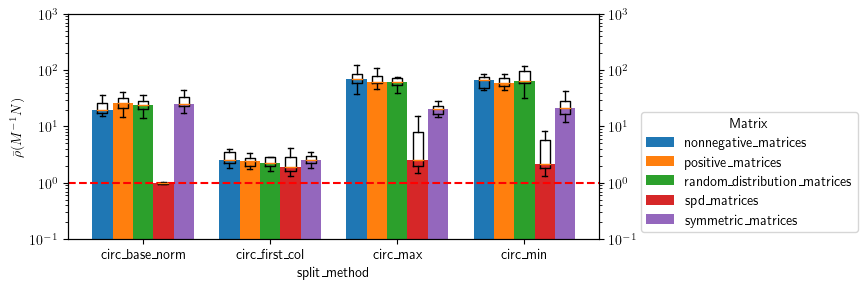

In [26]:
###
# BOXPLOTS (comparing methods and their spectral radii)
###
df.sort_values(by=['split_method'], inplace=True)

df_grouped = df.groupby(['matrix', 'split_method'])['rho'].median().reset_index()
pivot_df = df_grouped.pivot(index='split_method', columns='matrix', values='rho')
grouped = df.groupby(['matrix', 'split_method'])

boxplots = {}
# Iterating over each group to create individual boxplots
for (method, matrix), group in grouped:
    boxplots[(method, matrix)] = group['rho'].values

fig, ax = plt.subplots(figsize=(10,3))

ax2 = ax.twinx()
# Number of matrix types
num_matrix_types = len(pivot_df.columns)
# Width of each bar
bar_width = 0.8 / num_matrix_types
# Iterate over each matrix type to plot
for i, matrix_type in enumerate(pivot_df.columns):
    # Compute the positions for the bars
    bar_positions = np.arange(len(pivot_df)) + i * bar_width

    # Plotting
    ax.bar(bar_positions, pivot_df[matrix_type], width=bar_width, label=matrix_type)
    # ax.boxplot
    for j, method in enumerate(pivot_df.index):
        # Fetching the position for the current box plot
        box_pos = bar_positions[j]
        # Fetching the corresponding 'rho' values from boxplots dictionary
        if (matrix_type, method) in boxplots:
            rho_values = boxplots[(matrix_type, method)]
            # Adding a box plot for this specific data
            ax2.boxplot(rho_values, positions=[box_pos], widths=bar_width/2, manage_ticks=False, showfliers=False, meanline=True)

# Adjusting the x-axis to correctly align labels in the center of the group
ax.set_xticks(np.arange(len(pivot_df)) + bar_width * (num_matrix_types - 1) / 2)
ax.set_xticklabels(pivot_df.index)

# Other plot settings
plt.rcParams['text.usetex'] = True
ax.axhline(y=1, color='r', linestyle='--')
ax.set_yscale('log')
ax2.set_yscale('log')
ax.set_ylim(.1,1000)
ax2.set_ylim(.1,1000)
ax.set_xlabel('split_method')
ax.set_ylabel(r'$\bar{\rho}({M}^{-1}N)$')
# ax.set_title(r'$\bar{\rho}({M}^{-1}N)$ by Method for each Matrix Type')
ax.legend(title='Matrix', loc='lower right', bbox_to_anchor=(1.5,0))

plt.tight_layout()
plt.show()
fig.savefig(experiment_dir / 'boxplots.png', dpi=300)


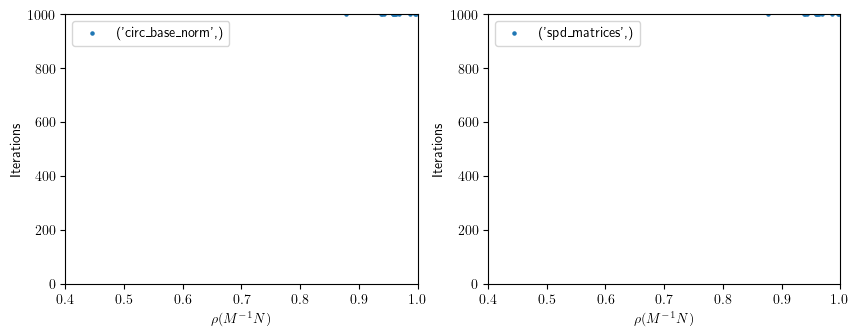

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3.5))

# GROUPED BY SPLITTING METHOD (M)
grouped = df.groupby(['split_method'])
for method, group in grouped:
    # Filter the group for rho < 1
    filtered_group = group[group['rho'] < 1]

    # Plotting the filtered group with a scatter plot in the first subplot
    if not filtered_group.empty:
        ax[0].scatter(filtered_group['rho'], filtered_group['iterations'], label=f'{method}',s=5)

ax[0].set_xlim(.4, 1)
ax[0].set_ylim(0, 1000)
ax[0].set_xlabel(r'$\rho({M}^{-1}N)$')
ax[0].set_ylabel('Iterations')
ax[0].legend(loc='upper left')

# GROUPED BY MATRIX TYPE
grouped = df.groupby(['matrix'])
for matrix, group in grouped:
    # Filter the group for rho < 1
    filtered_group = group[group['rho'] < 1]

    # Plotting the filtered group with a scatter plot in the second subplot
    if not filtered_group.empty:
        ax[1].scatter(filtered_group['rho'], filtered_group['iterations'], label=f'{matrix}',s=5)

ax[1].set_xlim(.4, 1)
ax[1].set_ylim(0, 1000)
ax[1].set_xlabel(r'$\rho({M}^{-1}N)$')
ax[1].set_ylabel('Iterations')
ax[1].legend(loc='upper left')

# Show the plot
plt.savefig(experiment_dir/'rho_vs_iter.png', dpi=300)
plt.show()


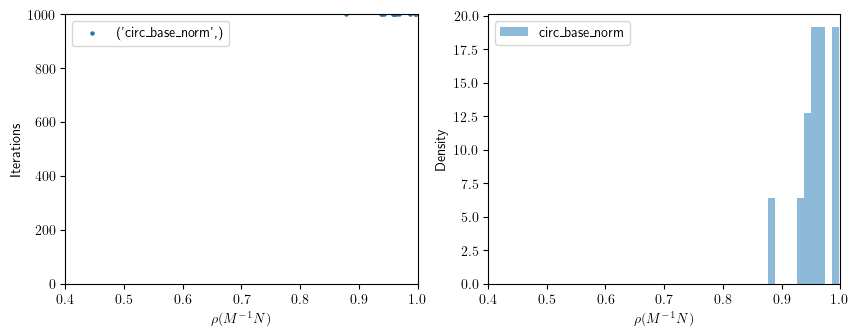

In [28]:

fig, ax = plt.subplots(1, 2, figsize=(10, 3.5))

filtered_df = df[df['rho'] < 1]

grouped = filtered_df.groupby(['split_method'])

# RHO VS ITER
for method, group in grouped:
    # Plotting the filtered group with a scatter plot in the first subplot
    if not group.empty:
        ax[0].scatter(group['rho'], group['iterations'], label=f'{method}',s=5)

ax[0].set_xlim(.4, 1)
ax[0].set_ylim(0, 1000)
ax[0].set_xlabel(r'$\rho({M}^{-1}N)$')
ax[0].set_ylabel('Iterations')
ax[0].legend(loc='upper left')

# RHO vs Density

for method, group in grouped:
    # Creating a histogram for the 'rho' values of each method group
    ax[1].hist(group['rho'], bins=10, alpha=0.5, label=method, density=True)

ax[1].set_xlim(.4, 1)
ax[1].set_xlabel(r'$\rho({M}^{-1}N)$')
ax[1].set_ylabel('Density')
ax[1].legend(loc='upper left')

# Show the plot
plt.savefig(experiment_dir/'mtx_split_dual_plot_iter_density.png', dpi=300)
plt.show()

